Importing the necessary packages and reading in the csv.

In [1]:
import pandas as pd
import sklearn
import math

listings = pd.read_csv('listings_seattle.csv')

Cleaning the data. Dropping columns, adding columns, fixing errors, converting data types, etc.

In [2]:
number_unique_id = listings['id'].value_counts()
listings.drop(labels='id', axis='columns', inplace=True) # contains useless info for a regression model
listings.drop(labels='requires_license', axis='columns', inplace=True) # only contains one value 'f'
listings.drop(labels='experiences_offered', axis='columns', inplace=True) # only contains one value 'none'
listings.drop(labels='market', axis='columns', inplace=True) # only contains one value 'Seattle'
listings.drop(labels='country_code', axis='columns', inplace=True) # only contains one value 'US'
listings.drop(labels='country', axis='columns', inplace=True) # only contains one value 'United States'
listings.drop(labels='license', axis='columns', inplace=True) # only contains one value 'NAN'
listings.drop(labels='jurisdiction_names', axis='columns', inplace=True) # only contains one value 'WASHINGTON'
listings.drop(labels='last_scraped', axis='columns', inplace=True) # only contains one value '2016-01-04'
listings.drop(labels='scrape_id', axis='columns', inplace=True) # only contains one value '20160104002432' and contains same info as listing_url and id
listings.drop(labels='city', axis='columns', inplace=True) # only contains one value 'a couple different variants of Seattle'
listings.drop(labels='state', axis='columns', inplace=True) # only contains 'Wa' and 'wa'
listings.drop(labels='smart_location', axis='columns', inplace=True) # Contains mostly Seattle and some other variants.
#listings.drop(labels='square_feet', axis='columns', inplace=True) # Most of the values contain na, will be dropped later.
listings.drop(labels='calendar_last_scraped', axis='columns', inplace=True) # Contains only 2016-01-04
listings.drop(labels='listing_url', axis='columns', inplace=True) # Contains the same info as id 
listings.drop(labels='thumbnail_url', axis='columns', inplace=True) # Contains useless info
listings.drop(labels='medium_url', axis='columns', inplace=True) # Contains useless info
listings.drop(labels='picture_url', axis='columns', inplace=True) # Contains useless info 
listings.drop(labels='xl_picture_url', axis='columns', inplace=True) # Contains useless info 
listings.drop(labels='host_url', axis='columns', inplace=True) # Contains useless info 
listings.drop(labels='host_thumbnail_url', axis='columns', inplace=True) # Contains useless info 
listings.drop(labels='host_picture_url', axis='columns', inplace=True) # Contains useless info 
listings.drop(labels='host_location', axis='columns', inplace=True) # Contains US (approxiately 7% differ)
listings.drop(labels='host_id', axis='columns', inplace=True) # Contains useless info
listings.drop(labels='host_name', axis='columns', inplace=True) # Contains useless info
listings.drop(labels='has_availability', axis='columns', inplace=True) # Only has two values that are 'f' out of 3818 total. The rest are 't'.
listings.drop(labels='street', axis='columns', inplace=True) # Would need a lot more time to make this a useful column

# These columns would have taken too long to process. I would have to do a lot of searching through the strings for 
#  keywords and most likely made dummy columns from those keywords. An example of a potential keyword is 'renovated'.
listings.drop(labels='name', axis='columns', inplace=True) #Would need a lot more time to make this a useful column
listings.drop(labels='summary', axis='columns', inplace=True) #Would need a lot more time to make this a useful column
listings.drop(labels='space', axis='columns', inplace=True) #Would need a lot more time to make this a useful column
listings.drop(labels='description', axis='columns', inplace=True) #Would need a lot more time to make this a useful column
listings.drop(labels='neighborhood_overview', axis='columns', inplace=True) #Would need a lot more time to make this a useful column
listings.drop(labels='notes', axis='columns', inplace=True) # Missing 1605 values. Has string <NA> as a string instead of null values
listings.drop(labels='transit', axis='columns', inplace=True) #This could definiety be a useful col. Search for bus, bike, uber, taxi, or rail.
listings.drop(labels='host_about', axis='columns', inplace=True) # Could search for positive descriptors to see a correlation between ratings
listings.drop(labels='host_neighbourhood', axis='columns', inplace=True)
listings.drop(labels='neighbourhood', axis='columns', inplace=True) # Could do dummy variables but that would make a lot of extra vars.
listings.drop(labels='amenities', axis='columns', inplace=True)
listings.drop(labels='calendar_updated', axis='columns', inplace=True)
listings.drop(labels='first_review', axis='columns', inplace=True)
listings.drop(labels='last_review', axis='columns', inplace=True)

# Error when inputting information
listings['zipcode'].replace('99\n98122','98122', inplace=True)


key = {'f': 0, 't': 1}
# Converting 't' and 'f' to usable columns.

listings[listings['host_is_superhost'].isna()]= 'f' # only two value had nan.
listings['host_is_superhost'] = listings['host_is_superhost'].map(key)# changes the f and t values to 0 and 1 values respectively
listings['host_is_superhost'] = listings['host_is_superhost'].astype('int64')
listings[listings['host_has_profile_pic'].isna()]= 'f' # only two value had nan.
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].map(key) 
listings[listings['host_identity_verified'].isna()]= 'f' # only two value had nan.
listings['host_identity_verified'] = listings['host_identity_verified'].map(key)
listings['is_location_exact'] = listings['is_location_exact'].map(key)
listings['instant_bookable'] = listings['instant_bookable'].map(key)
listings['require_guest_profile_picture'] = listings['require_guest_profile_picture'].map(key)
listings['require_guest_phone_verification'] = listings['require_guest_phone_verification'].map(key)
#listings['has_availability'].map(key) # only has two value that are f out of 3818 total
listings = listings[listings['host_since'] != 'f']

listings = listings[listings['property_type'].notnull()] # The one missing value. More practicle to exclude it then assign it a value
listings = listings.convert_dtypes()

# '2016-01-04' is used because it is when the data was scraped. Converting time_hosted to time hosted since they started
listings['time_hosted'] = (pd.Timestamp('2016-01-04') - pd.to_datetime(listings['host_since'], format="%Y-%m-%d"))
listings['time_hosted'].dt.days.astype('int64')
listings.drop(labels='host_since', axis='columns', inplace=True)
#When converting to int64 the division was necessary to return to the correct number. 
listings['time_hosted'] = listings['time_hosted'].astype('int64')/(24*60*60*1000000000)

# Converting strings with percentages to decimals.
listings['host_response_rate'] = listings['host_response_rate'].str.rstrip("%").astype('float64')/100
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.rstrip("%").astype('float64')/100

# Converting strings with dollar sign and commas to a float.
listings['price'] = listings['price'].str.replace(",","").str.lstrip("$").astype('float64')
listings['weekly_price'] = listings['weekly_price'].str.replace(",","").str.lstrip("$").astype('float64')
listings['monthly_price'] = listings['monthly_price'].str.replace(",","").str.lstrip("$").astype('float64')
listings['security_deposit'] = listings['security_deposit'].str.replace(",","").str.lstrip("$").astype('float64')
listings['cleaning_fee'] = listings['cleaning_fee'].str.replace(",","").str.lstrip("$").astype('float64')
listings['extra_people'] = listings['extra_people'].str.replace(",","").str.lstrip("$").astype('float64')

# Centers the latitude and longitude around the center of seattle
listings['latitude'] = listings['latitude']-47.6062
listings['longitude'] = listings['longitude']+122.3321

# dropping columns with approximately half of the values missing. 
cols_thresh = math.floor(len(listings)*0.5)
listings.dropna(axis=1, thresh=cols_thresh, inplace=True) # columns

# Imputes the missing values with the mean of the columns.
num_vars = listings.select_dtypes(include=['Float64', 'float64', 'timedelta64']).columns
for col in num_vars:
    listings[col].fillna((listings[col].mean()), inplace=True)
    
# Imputes the missing values with the median of the columns
int_vars = ['bedrooms', 'beds']
for col in int_vars:
    listings[col].fillna((listings[col].median()), inplace=True)

#neighbourhood_group_cleansed can be a dummy_variable but what does it mean
dummy_variable_cols = ['host_response_time', 'zipcode', 'property_type', 'room_type',
                       'bed_type', 'cancellation_policy']

for var in  dummy_variable_cols:
    # for each cat add dummy var, drop original column
    listings = pd.concat([listings.drop(var, axis=1),
                          pd.get_dummies(listings[var], prefix=var, prefix_sep='_', 
                                         drop_first=False, dummy_na=False, dtype='int64')], axis=1)


In [3]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3815 entries, 0 to 3817
Data columns (total 100 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   host_response_rate                     3815 non-null   float64
 1   host_acceptance_rate                   3815 non-null   float64
 2   host_is_superhost                      3815 non-null   Int64  
 3   host_listings_count                    3815 non-null   Int64  
 4   host_total_listings_count              3815 non-null   Int64  
 5   host_verifications                     3815 non-null   string 
 6   host_has_profile_pic                   3815 non-null   Int64  
 7   host_identity_verified                 3815 non-null   Int64  
 8   neighbourhood_cleansed                 3815 non-null   string 
 9   neighbourhood_group_cleansed           3815 non-null   string 
 10  latitude                               3815 non-null   Float64
 11  lon

Splitting the data into a train and test set and creating a random forest regressor. 

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# review_scores columns are chosen after the price has been paid. Missing about 20% of its data

# This drops review scores and any other columns missing data. 
complete_listings = listings.dropna(axis=1, how='any')

# Drops string variable that would take longer to analyze and price which is the y variable.
X = complete_listings.drop(labels=['price', 'host_verifications', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed'],
                           axis='columns', inplace=False)


y = complete_listings['price'].copy()

# Splits the data into two parts. The training set consists of 80% of the total data and the test is 20% of the data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

random_for = RandomForestRegressor(n_estimators = 300 ,random_state=42, verbose=False)

print('Training Started')

random_for.fit(X_train, y_train)

print('Training Ended')

y_pred = random_for.predict(X_test)

print(r2_score(y_train, random_for.predict(X_train)), 'training error')

print(r2_score(y_test, y_pred), 'test error')

Training Started
Training Ended
0.952291390246715 training error
0.7729490574566814 test error


Prints out the columns and feature importances value which are greater than 0.018, which is a threshold I found to give me the top 10 features.

In [5]:
for column, feat_import in zip(X.columns, random_for.feature_importances_):
    if feat_import > 0.018:
        print(column, ':',feat_import)
    else:
        pass

latitude : 0.026608457252763215
longitude : 0.02092788277750534
accommodates : 0.037568736226114154
bathrooms : 0.07936504888040455
bedrooms : 0.36542064989890133
weekly_price : 0.14158503471511968
cleaning_fee : 0.030596795118037746
availability_365 : 0.021958053809358103
reviews_per_month : 0.030345534419367347
room_type_Entire home/apt : 0.04494701015275384


Creates a dataframe with the features and feature importance so that they can be sorted by their values and so that you could create a simplified model if you so chose to. 

In [6]:
name_feat = list(zip(X.columns, random_for.feature_importances_))
feature_importance_df = pd.DataFrame(name_feat, columns =['Column', 'Feature Importance'])

#feature_importance_df.sort_values(by='Feature Importance', ascending=False)['Feature Importance'][0:19].sum() # = 0.899
feature_importance_df.sort_values(by='Feature Importance', ascending=False)[0:19]

,Column,Feature Importance
12,bedrooms,0.365421
14,weekly_price,0.141585
11,bathrooms,0.079365
78,room_type_Entire home/apt,0.044947
10,accommodates,0.037569
15,cleaning_fee,0.030597
29,reviews_per_month,0.030346
7,latitude,0.026608
23,availability_365,0.021958
8,longitude,0.020928


What is the best price for a single bedroom/single bathroom? 
What month has the highest prices?

In [7]:
central_zipcodes = ['zipcode_98119', 'zipcode_98109', 'zipcode_98102', 'zipcode_98112',
                    'zipcode_98121', 'zipcode_98101', 'zipcode_98122', 'zipcode_98104']


for code in central_zipcodes:
    print('Mean price of a single bedroom, single bathroom in', code,
         '${:.2f}'.format(listings[(listings[code]== True) & (listings['bedrooms']== 1) & (listings['bathrooms']==1)]['price'].mean()))


Mean price of a single bedroom, single bathroom in zipcode_98119 $106.64
Mean price of a single bedroom, single bathroom in zipcode_98109 $117.90
Mean price of a single bedroom, single bathroom in zipcode_98102 $106.18
Mean price of a single bedroom, single bathroom in zipcode_98112 $104.45
Mean price of a single bedroom, single bathroom in zipcode_98121 $133.36
Mean price of a single bedroom, single bathroom in zipcode_98101 $147.64
Mean price of a single bedroom, single bathroom in zipcode_98122 $100.29
Mean price of a single bedroom, single bathroom in zipcode_98104 $131.91


Imports the calendar seattle file which contains listing_id, listing dates in 2016 mostly, availability, and price for the listings.

In [8]:
calendar_seattle = pd.read_csv('calendar_seattle.csv')
calendar_seattle.iloc[0:10,:]

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
5,241032,2016-01-09,f,NaN
6,241032,2016-01-10,f,NaN
7,241032,2016-01-11,f,NaN
8,241032,2016-01-12,f,NaN
9,241032,2016-01-13,t,$85.00


In [9]:
calendar_seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


Converts the available column to ints. Drops any rows without pricing and converts the dates to date format.

In [10]:
calendar_seattle['available'] = calendar_seattle['available'].map(key).copy()
calendar_seattle.dropna(axis=0, how='any', inplace=True)
calendar_seattle['date'] = pd.to_datetime(calendar_seattle['date'], format="%Y-%m-%d")

Histogram of the prices in calendar_seattle dataframe.

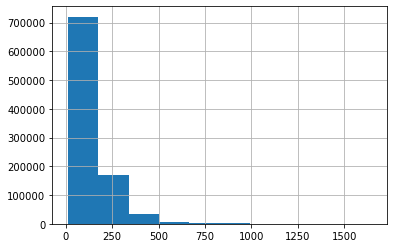

In [14]:
calendar_seattle['price'].hist();

Creates months booleans so that the listings could be split into months. 

In [12]:
calendar_seattle.loc[(calendar_seattle['date']>=pd.to_datetime('2016-01-01', format="%Y-%m-%d")) &
                                           (calendar_seattle['date']<=pd.to_datetime('2016-01-31', format="%Y-%m-%d")),
                     'Jan'] = True
calendar_seattle.loc[(calendar_seattle['date']>=pd.to_datetime('2016-02-01', format="%Y-%m-%d")) &
                                           (calendar_seattle['date']<=pd.to_datetime('2016-02-28', format="%Y-%m-%d")),
                     'Feb'] = True
calendar_seattle.loc[(calendar_seattle['date']>=pd.to_datetime('2016-03-01', format="%Y-%m-%d")) &
                                           (calendar_seattle['date']<=pd.to_datetime('2016-03-31', format="%Y-%m-%d")),
                     'Mar'] = True
calendar_seattle.loc[(calendar_seattle['date']>=pd.to_datetime('2016-04-01', format="%Y-%m-%d")) &
                                           (calendar_seattle['date']<=pd.to_datetime('2016-04-30', format="%Y-%m-%d")),
                     'Apr'] = True
calendar_seattle.loc[(calendar_seattle['date']>=pd.to_datetime('2016-05-01', format="%Y-%m-%d")) &
                                           (calendar_seattle['date']<=pd.to_datetime('2016-05-31', format="%Y-%m-%d")),
                     'May'] = True
calendar_seattle.loc[(calendar_seattle['date']>=pd.to_datetime('2016-06-01', format="%Y-%m-%d")) &
                                           (calendar_seattle['date']<=pd.to_datetime('2016-06-30', format="%Y-%m-%d")),
                     'Jun'] = True
calendar_seattle.loc[(calendar_seattle['date']>=pd.to_datetime('2016-07-01', format="%Y-%m-%d")) &
                                           (calendar_seattle['date']<=pd.to_datetime('2016-07-31', format="%Y-%m-%d")),
                     'Jul'] = True
calendar_seattle.loc[(calendar_seattle['date']>=pd.to_datetime('2016-08-01', format="%Y-%m-%d")) &
                                           (calendar_seattle['date']<=pd.to_datetime('2016-08-31', format="%Y-%m-%d")),
                     'Aug'] = True
calendar_seattle.loc[(calendar_seattle['date']>=pd.to_datetime('2016-09-01', format="%Y-%m-%d")) &
                                           (calendar_seattle['date']<=pd.to_datetime('2016-09-30', format="%Y-%m-%d")),
                     'Sep'] = True
calendar_seattle.loc[(calendar_seattle['date']>=pd.to_datetime('2016-10-01', format="%Y-%m-%d")) &
                                           (calendar_seattle['date']<=pd.to_datetime('2016-10-31', format="%Y-%m-%d")),
                     'Oct'] = True
calendar_seattle.loc[(calendar_seattle['date']>=pd.to_datetime('2016-11-01', format="%Y-%m-%d")) &
                                           (calendar_seattle['date']<=pd.to_datetime('2016-11-30', format="%Y-%m-%d")),
                     'Nov'] = True
calendar_seattle.loc[(calendar_seattle['date']>=pd.to_datetime('2016-12-01', format="%Y-%m-%d")) &
                                           (calendar_seattle['date']<=pd.to_datetime('2016-12-31', format="%Y-%m-%d")),
                     'Dec'] = True

calendar_seattle.fillna(False)

calendar_seattle['price'] = calendar_seattle['price'].str.replace(",","").str.lstrip("$").astype('float64')

Calculates the mean price of each month

In [13]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for mon in months:
    print('The average price for the month of', mon, 'is',
          '${:.2f}'.format(calendar_seattle[calendar_seattle[mon]==True]['price'].mean()))

The average price for the month of Jan is $121.57
The average price for the month of Feb is $124.39
The average price for the month of Mar is $128.64
The average price for the month of Apr is $135.10
The average price for the month of May is $139.54
The average price for the month of Jun is $147.47
The average price for the month of Jul is $152.09
The average price for the month of Aug is $150.66
The average price for the month of Sep is $143.26
The average price for the month of Oct is $137.03
The average price for the month of Nov is $135.69
The average price for the month of Dec is $137.25
